<div style="text-align: right"> [CMSC 636] Drake Wong </div>

In [1]:
import os 
# Note: If GPU memory in inadequate, uncomment os.environ statements to use system memory and CPU
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import keras 
import tensorflow 
import random
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras import regularizers
from keras.callbacks import History 

# Instructions:
# Seperate histograms of each gene into folders, which are named after their category
DATADIR=r"C:\Users\drake\Google Drive\ILS Spring 2020 Semester\CMSC 636 Deep Learning\Project - Code\02 Create Histograms\20_04_18 10 categories large"
categories =["BMDC","Brain","CD4","CD4memory","CD8","Haematopoietic","intestinal","Lung","Mammery","Olfactory"]

Using TensorFlow backend.


In [2]:
# Check devince
if tensorflow.test.gpu_device_name():
    print('GPU has been found')
else:
    print("No GPU has been found")


GPU has been found


In [4]:
img_size= 125
training_data=[]

def create_training_data(): 
    for category in categories:
        path= os.path.join(DATADIR, category) # path to different categories 
        for img in os.listdir(path):
            try:
                img_array= cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array= cv2.resize(img_array, (img_size, img_size))
                training_data.append([new_array, category])
            except Exception as e:
                pass
create_training_data()
random.shuffle(training_data)
print(f"In total, {len(training_data)} samples have been loaded among the {len(categories)} categories")


In total, 22990 samples have been loaded among the 10 categories


In [5]:
# Create list of training data and labels 
train_data=[]
train_label=[]
for features, label in training_data:
    train_data.append(features)
    train_label.append(label)
train_data=np.array(train_data).reshape(-1,img_size, img_size,1)

In [7]:
# Convert categories to numeric representation
convert_to_numeric = LabelEncoder()
y_train_num = convert_to_numeric.fit_transform(train_label)

In [30]:
# MODEL
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.model_selection import StratifiedKFold

accuracy = []
val_accuracy = []

seed=7
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
for train, test in kfold.split(train_data, y_train_num):
    
    y_train_matrix = to_categorical(y_train_num)
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), input_shape=train_data.shape[1:], strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(64, (3, 3), strides=1,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))# the model so far outputs 3D feature maps (height, width, features)

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64, input_dim=64,
                    kernel_regularizer=regularizers.l2(0.01),
                    activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    # COMPILE
    model.compile(loss='mean_squared_error',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    final_model=model.fit(train_data[train],
              y_train_matrix[train],
              validation_data=(train_data[test], y_train_matrix[test]),
              epochs=120,
              batch_size=500,
              verbose=2)
    
    accuracy.append(final_model.history['accuracy'][-1])
    val_accuracy.append(final_model.history['val_accuracy'][-1])
print('accuracy:', accuracy, "\nval_accuracy: ", val_accuracy, 
      "\nmean_acc: ", sum(accuracy)/len(accuracy),
      "\nmean_val_acc: ", sum(val_accuracy)/len(val_accuracy))

Train on 20691 samples, validate on 2299 samples
Epoch 1/120
 - 22s - loss: 0.3753 - accuracy: 0.0996 - val_loss: 0.2039 - val_accuracy: 0.1000
Epoch 2/120
 - 23s - loss: 0.1943 - accuracy: 0.1023 - val_loss: 0.1912 - val_accuracy: 0.1000
Epoch 3/120
 - 22s - loss: 0.1904 - accuracy: 0.0994 - val_loss: 0.1900 - val_accuracy: 0.1000
Epoch 4/120
 - 23s - loss: 0.1909 - accuracy: 0.1017 - val_loss: 0.1911 - val_accuracy: 0.1000
Epoch 5/120
 - 23s - loss: 0.1396 - accuracy: 0.1663 - val_loss: 0.0905 - val_accuracy: 0.2388
Epoch 6/120
 - 22s - loss: 0.0890 - accuracy: 0.2584 - val_loss: 0.0825 - val_accuracy: 0.3162
Epoch 7/120
 - 24s - loss: 0.0847 - accuracy: 0.3056 - val_loss: 0.0796 - val_accuracy: 0.3662
Epoch 8/120
 - 22s - loss: 0.0824 - accuracy: 0.3336 - val_loss: 0.0773 - val_accuracy: 0.4002
Epoch 9/120
 - 23s - loss: 0.0807 - accuracy: 0.3618 - val_loss: 0.0774 - val_accuracy: 0.3989
Epoch 10/120
 - 23s - loss: 0.0804 - accuracy: 0.3681 - val_loss: 0.0758 - val_accuracy: 0.4067


In [31]:
# Save last model results to file
model.save("Model_Weights.h5")

In [32]:
# Loop through categories. Check overall accuracy. 
for x, c in enumerate(categories):
    count = 0
    IMAGES = r"C:\Users\drake\Google Drive\ILS Spring 2020 Semester\CMSC 636 Deep Learning\Project - Code\02 Create Histograms\20_04_18 10 categories large"
    IMAGES += "\\" + c
    onlyfiles = [f for f in os.listdir(IMAGES) if os.path.isfile(os.path.join(IMAGES, f))]
    

    for i, name in enumerate(onlyfiles):
        img_array= cv2.imread(os.path.join(DATADIR, c, onlyfiles[i]), cv2.IMREAD_GRAYSCALE)
        reshaped_array=cv2.resize(img_array, (img_size, img_size))
        reshaped_array=np.array(reshaped_array).reshape(-1,img_size, img_size,1)
        pred=model.predict(reshaped_array)
        if np.argmax(pred) == x:
            count += 1
    print(f"For {c}, {count} were properly classified")       


For BMDC, 1639 were properly classified
For Brain, 580 were properly classified
For CD4, 856 were properly classified
For CD4memory, 1750 were properly classified
For CD8, 794 were properly classified
For Haematopoietic, 2001 were properly classified
For intestinal, 349 were properly classified
For Lung, 224 were properly classified
For Mammery, 217 were properly classified
For Olfactory, 19 were properly classified


0
['BMDC' 'Brain' 'CD4' 'CD4memory' 'CD8' 'Haematopoietic' 'Lung' 'Mammery'
 'Olfactory' 'intestinal']


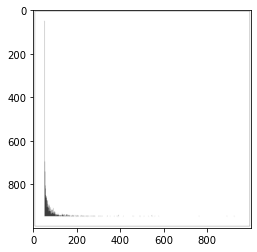

In [33]:
# Individually check histograms
selected_category = 'BMDC'
img_array= cv2.imread(os.path.join(DATADIR, selected_category, onlyfiles[random.randint(0,2300)]), cv2.IMREAD_GRAYSCALE)
plt.imshow(img_array, cmap="gray")
reshaped_array=cv2.resize(img_array, (img_size, img_size))
reshaped_array=np.array(reshaped_array).reshape(-1,img_size, img_size,1)
pred=model.predict(reshaped_array)
print(np.argmax(pred))
print(convert_to_numeric.inverse_transform([0,1,2,3,4,5,6,7,8,9]))


In [1]:
# Clears GPU memory 
from numba import cuda 
device = cuda.get_current_device()
device.reset()